In [79]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pathlib import Path

In [80]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [81]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [82]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [83]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [84]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [85]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [86]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [87]:
# Find the most recent date in the data set.
Date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(Date)

('2017-08-23',)


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-27'),
  Text(0.0, 0, '2016-08-23'),
  Text(500.0, 0, '2016-11-09'),
  Text(1000.0, 0, '2017-01-28'),
  Text(1500.0, 0, '2017-04-18'),
  Text(2000.0, 0, '2017-07-10'),
  Text(2500.0, 0, '')])

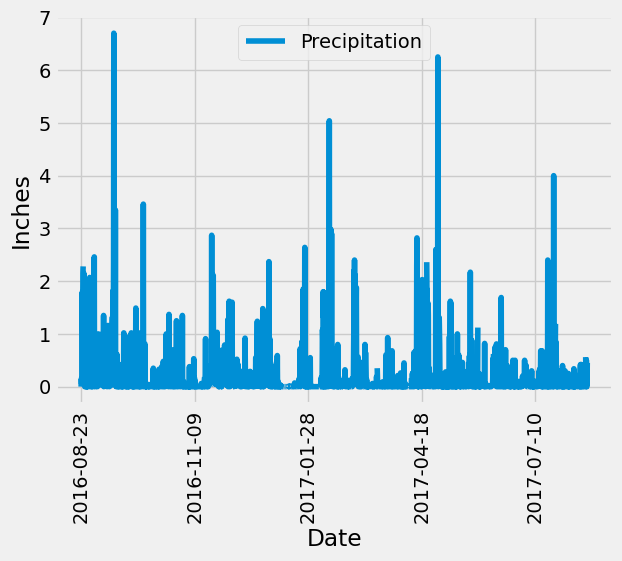

In [88]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(Date[0], '%Y-%m-%d')
year = last_date - dt.timedelta(days = 366)

# Perform a query to retrieve the data and precipitation scores

Annual = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= year).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
Annual_df = pd.DataFrame(Annual, columns = ['Measurement_Date', 'Precipitation'])
final_df = Annual_df.set_index('Measurement_Date')

# Sort the dataframe by date
final_df.sort_values(by = 'Measurement_Date')

# Use Pandas Plotting with Matplotlib to plot the data
Precipitation = final_df.plot(xlabel = 'Date', ylabel = 'Inches') 
plt.xticks(rotation = 90)


In [89]:
# Use Pandas to calculate the summary statistics for the precipitation data
final_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [90]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(distinct(Measurement.station))).all()

[(9,)]

In [91]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
Active = session.query(Measurement.station, func.count(Measurement.station)).\
        order_by(func.count(Measurement.station).desc()).\
        group_by(Measurement.station).all()
Active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [92]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
Most = session.query(Measurement.station, func.min(Measurement.tobs), 
                     func.max(Measurement.tobs),
                     func.avg(Measurement.tobs)).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in Most:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


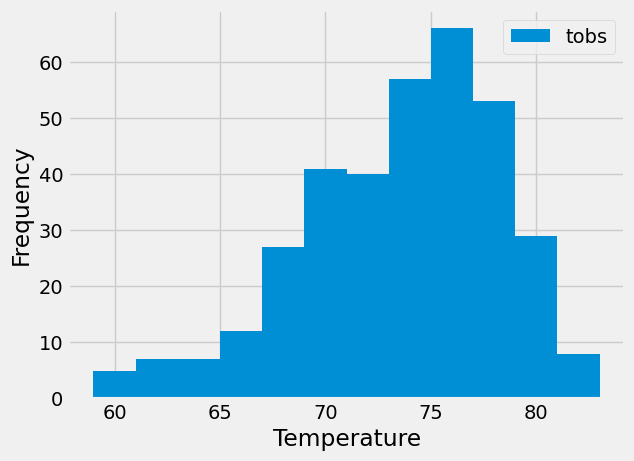

In [94]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Obs = session.query(Measurement.date, Measurement.tobs).\
        filter(func.strftime(Measurement.date) >= year, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
Obs_df = pd.DataFrame(Obs, columns = ['Measurement_Date', 'Temperature'])

plt.hist(Obs_df['Temperature'], bins = 12, density = False, label = "tobs") 
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()


# Close Session

In [95]:
# Close Session
session.close()